In [1]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.dataloader import default_collate

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)

def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

/home/jupyter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [2]:
# training parameters

batch_size = 128
lr = 0.0002
train_epoch = 20

img_size = 64

def my_collate(batch):
    modified_batch = []
    for item in batch:
        image, label = item
        if label is not 9:
            modified_batch.append(item)
    return default_collate(modified_batch)

transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, collate_fn = my_collate)

# network
G = generator(128)
D = discriminator(128)

G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
num_iter = 0

/home/jupyter/.local/lib/python3.5/site-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [3]:
print(type(train_loader))

count = 0

for x_, y in train_loader:
    count+= 1
    # print(x_)
    print(y)
    if count == 1:
        break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([0, 5, 8, 3, 0, 8, 0, 5, 4, 1, 6, 6, 5, 3, 8, 5, 0, 1, 5, 6, 3, 0, 6, 0,
        4, 1, 3, 3, 3, 3, 7, 3, 8, 4, 4, 7, 1, 6, 6, 2, 0, 3, 6, 1, 0, 3, 0, 3,
        7, 0, 6, 2, 1, 0, 8, 0, 3, 3, 5, 6, 1, 1, 4, 3, 2, 0, 5, 8, 5, 7, 8, 2,
        4, 8, 2, 3, 5, 5, 5, 1, 6, 7, 1, 6, 6, 7, 7, 2, 5, 4, 3, 0, 2, 7, 3, 7,
        0, 4, 8, 5, 8, 2, 0, 2, 1, 3, 5, 0, 5, 1, 3, 2, 0, 3, 2])


In [ ]:
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    print("epoch number", epoch)
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        # D_losses.append(D_train_loss.data[0])
        D_losses.append(D_train_loss.data)

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data)

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'MNIST_DCGAN_results/Random_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), "MNIST_DCGAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_DCGAN_results/discriminator_param.pkl")
with open('MNIST_DCGAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
    
    

show_train_hist(train_hist, save=True, path='MNIST_DCGAN_results/MNIST_DCGAN_train_hist.png')

images = []
for e in range(train_epoch):
    img_name = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_DCGAN_results/generation_animation.gif', images, fps=5)

training start!
epoch number 0


/home/jupyter/.local/lib/python3.5/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/jupyter/.local/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


# Few Shot Generation using the saved model

### When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s state_dict with the torch.save() function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.

- Loading saved model and making predictions on nine

To save models, we used:

- torch.save(G.state_dict(), "MNIST_DCGAN_results/generator_param.pkl")
- torch.save(D.state_dict(), "MNIST_DCGAN_results/discriminator_param.pkl")

In [57]:
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile=True)

    g_model.eval()
    if isFix:
        test_images = g_model(fixed_z_)
    else:
        test_images = g_model(z_)
    g_model.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [58]:
g_model = generator(128)
g_model.load_state_dict(torch.load("MNIST_DCGAN_results/generator_param.pkl"))
g_model.eval()

d_model = discriminator(128)
d_model.load_state_dict(torch.load("MNIST_DCGAN_results/discriminator_param.pkl"))
d_model.eval()

discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [59]:
g_model.cuda()
d_model.cuda()

discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [60]:
# Print generator state_dict
# print("Generator's state_dict:")
# for param_tensor in g_model.state_dict():
#     print(param_tensor, "\t", g_model.state_dict()[param_tensor].size())

In [61]:
# print("Discriminator's state_dict:")
# for param_tensor in d_model.state_dict():
#     print(param_tensor, "\t", d_model.state_dict()[param_tensor].size())  

In [62]:
# initializing parameters
batch_size = 1
lr = 0.0001
train_epoch = 100
img_size = 64

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(g_model.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(d_model.parameters(), lr=lr, betas=(0.5, 0.999))

# training related parameters
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

In [63]:
# results save folder
if not os.path.isdir('NINE_results'):
    os.mkdir('NINE_results')
if not os.path.isdir('NINE_results/Random_results'):
    os.mkdir('NINE_results/Random_results')
if not os.path.isdir('NINE_results/Fixed_results'):
    os.mkdir('NINE_results/Fixed_results')

In [64]:
# Getting some images of nine ready for inference:

transform = transforms.Compose([
        transforms.ColorJitter(),
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root='nine_data', train=True, download=True, transform=transform)

idx = dataset.targets == 9

dataset.data = dataset.data[idx]
dataset.targets = dataset.targets[idx]

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [65]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._DataLoaderIter'>
images shape on batch size = torch.Size([1, 1, 64, 64])
labels shape on batch size = torch.Size([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '[9]')

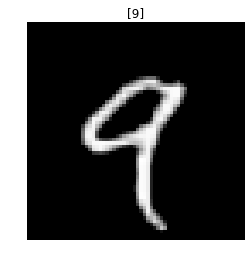

In [66]:
import torchvision

grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy())

In [67]:
# see if train_loader is giving only nines
print(type(train_loader))

count = 0

for x_, y in train_loader:
    count+= 1
    # print(x_)
    print(y)
    if count == 5:
        break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([9])
tensor([9])
tensor([9])
tensor([9])
tensor([9])


In [68]:
# create data to be trained upon: around 200 images

train_custom_data = []

for i in range(1, 52):
    count = 0
    for item in train_loader:
        train_custom_data.append(item)
        count += 1
        if count == 4:
            break

In [69]:
print(len(train_custom_data))

204


In [70]:
num_iter = 0

print('Fine tuning starts!')

start_time = time.time()

for epoch in range(train_epoch):
    
    print("epoch number", epoch)
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    
    # Few shot, remember?
    count = 0
    
    for x_, _ in train_custom_data:
        
        # train discriminator D
        d_model.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = d_model(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        G_result = g_model(z_)

        D_result = d_model(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        # D_losses.append(D_train_loss.data[0])
        D_losses.append(D_train_loss.data)

        # train generator G
        g_model.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = g_model(z_)
        D_result = d_model(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data)

        num_iter += 1
        count += 1

    print("count in epoch: " + str(epoch) + " is: " + str(count))    
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'NINE_results/Random_results/NINE_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'NINE_results/Fixed_results/NINE_DCGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

Fine tuning starts!
epoch number 0
count in epoch: 0 is: 204
[1/100] - ptime: 3.69, loss_d: 0.457, loss_g: 9.983


/home/jupyter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


epoch number 1
count in epoch: 1 is: 204
[2/100] - ptime: 3.74, loss_d: 0.523, loss_g: 10.132
epoch number 2
count in epoch: 2 is: 204
[3/100] - ptime: 3.72, loss_d: 0.217, loss_g: 9.160
epoch number 3
count in epoch: 3 is: 204
[4/100] - ptime: 3.71, loss_d: 0.215, loss_g: 7.979
epoch number 4
count in epoch: 4 is: 204
[5/100] - ptime: 3.72, loss_d: 0.581, loss_g: 6.350
epoch number 5
count in epoch: 5 is: 204
[6/100] - ptime: 3.80, loss_d: 0.510, loss_g: 4.767
epoch number 6
count in epoch: 6 is: 204
[7/100] - ptime: 3.79, loss_d: 0.627, loss_g: 2.917
epoch number 7
count in epoch: 7 is: 204
[8/100] - ptime: 3.75, loss_d: 0.693, loss_g: 2.266
epoch number 8
count in epoch: 8 is: 204
[9/100] - ptime: 3.76, loss_d: 0.710, loss_g: 1.988
epoch number 9
count in epoch: 9 is: 204
[10/100] - ptime: 3.78, loss_d: 0.703, loss_g: 1.884
epoch number 10
count in epoch: 10 is: 204
[11/100] - ptime: 3.79, loss_d: 0.706, loss_g: 1.826
epoch number 11
count in epoch: 11 is: 204
[12/100] - ptime: 3.78